In [1]:
from Network_PER import *
from DriveSimTrace import *
import shap

pygame 2.1.2 (SDL 2.0.18, Python 3.10.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


SHAP, Decomposed Reward 정보를 통한 설명 텍스트 생성

In [2]:
pred_label = ["reach finish line", "avoid the obstacle", "avoid the wall"]
action_label = ["Idle", "Accel", "Decel", "Turn Left", "Turn Right"]
state_label = ["Speed","Rotation","Agent X","Agent Y",\
    "Obs X","Obs Y","Obs Size"]

def pred_explain(pred_list):

    pred_sum = np.sum(pred_list, axis=0)
    chosen = np.argmax(pred_sum)
    compare = np.argmin(pred_sum)

    diff = np.transpose(pred_list)[chosen] - np.transpose(pred_list)[compare]
    diff = diff[0]

    txt = [f"I chose '{action_label[chosen]}' rather than '{action_label[compare]}' because it seemed more likely to help me ",""]
    
    for i in range(np.size(diff)):
        if diff[i] > 0:
            txt[1] += f"{pred_label[i]}(+{ str(round(diff[i], 2)) })/"
    
    txt[1] = txt[1][:-1] + "."

    return txt, chosen, compare

def shap_explain(shap_list):
    shap_list_abs = np.abs(shap_list)
    imp1 = np.argmax(shap_list_abs)
    imp1val = shap_list[imp1]
    shap_list_abs[imp1] = -1

    imp2 = np.argmax(shap_list_abs)
    imp2val = shap_list[imp2]

    txt = [f"I considered '{state_label[imp1]}'({ str(round(imp1val, 3)) }) and '{state_label[imp2]}'({ str(round(imp2val, 3)) })",\
     f"the most important in making this decision."]
    return txt

# def hesitation(pred_list):
#     pred_sum = np.sum(pred_list, axis=0)[0]

#     M1 = np.argmax(pred_sum)
#     pM1 = pred_sum[M1]
#     pred_sum[M1] = -100000
#     M2 = np.argmax(pred_sum)
#     pM2 = pred_sum[M2]
    
#     s = 0
#     for i in range(3):
#         piM1 = pred_list[i][0,M1]
#         piM2 = pred_list[i][0,M2]
#         s += (piM1-piM2)**2
#     s = sqrt(s)
#     s /= (pM1 - pM2 + 1e-7)
    
#     print(pM1, pM2, action_label[M1], action_label[M2])

#     return s


시뮬레이션 설명

Use Prioritized Sampling: False
loaded weights from ./models/q_20230226(0)
0
1


reach finish line


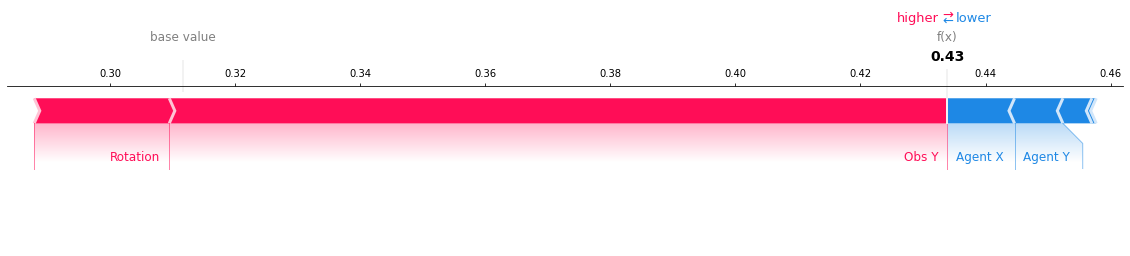

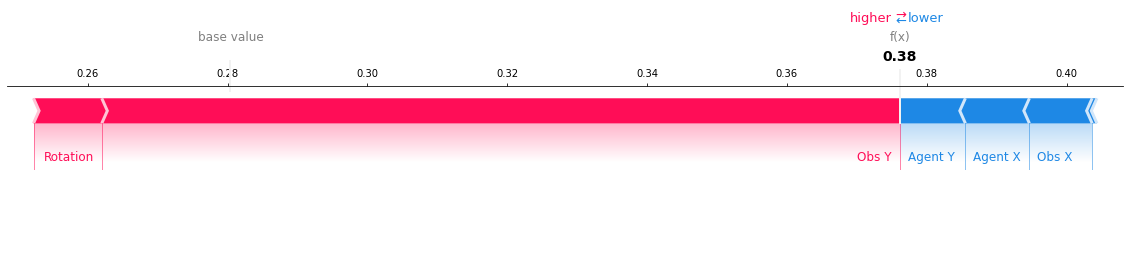

avoid the obstacle


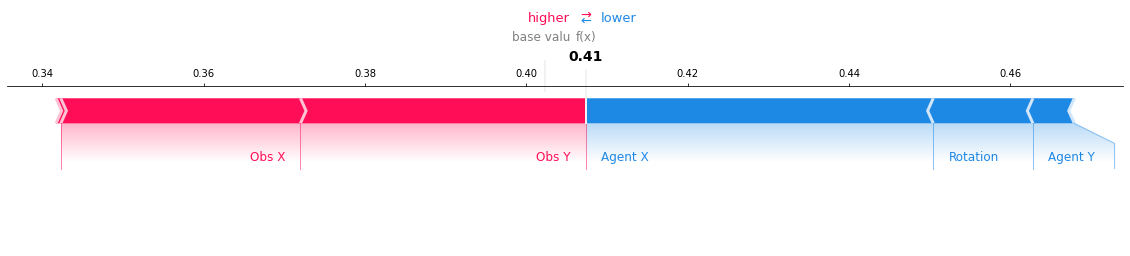

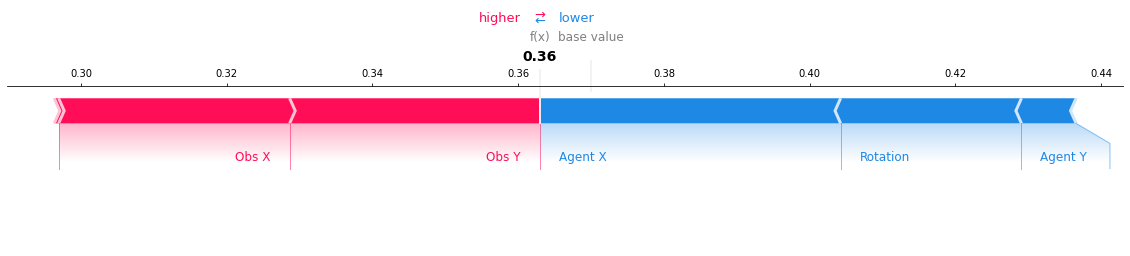

avoid the wall


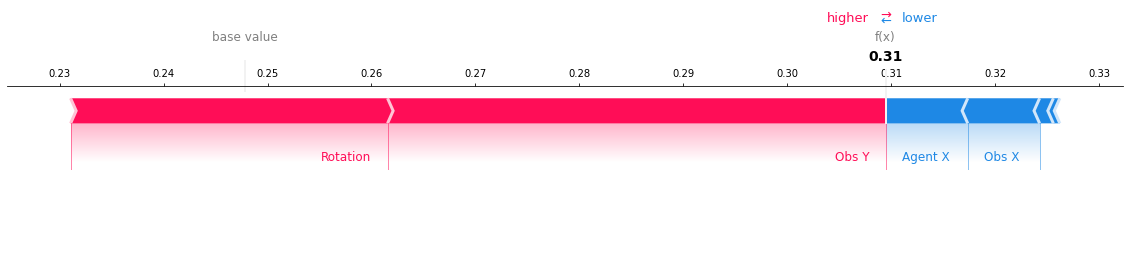

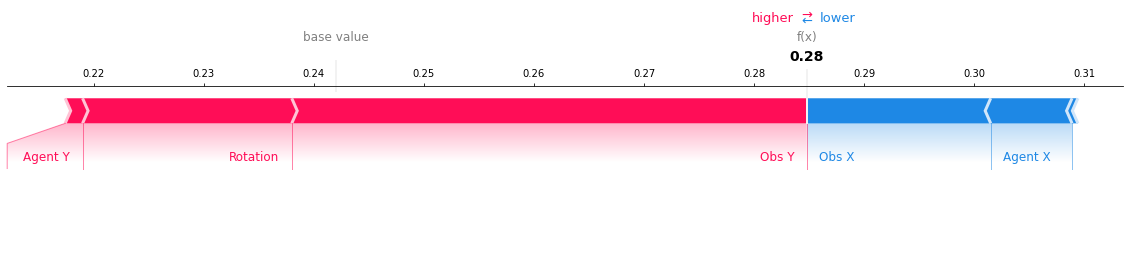

asdf
2


reach finish line


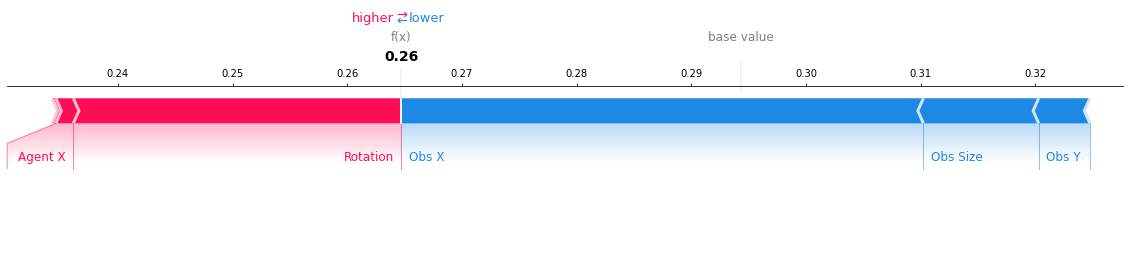

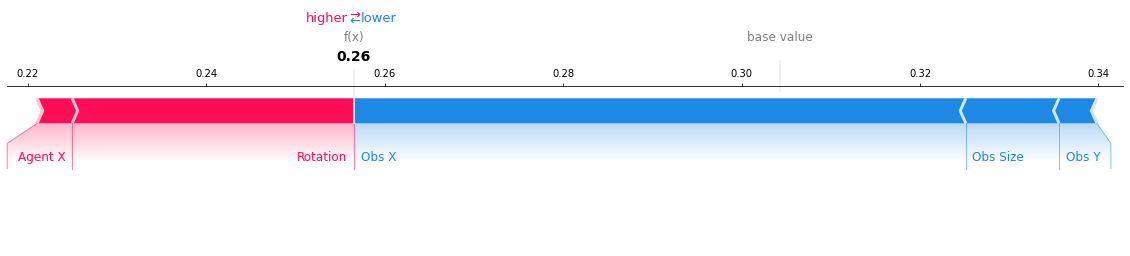

avoid the obstacle


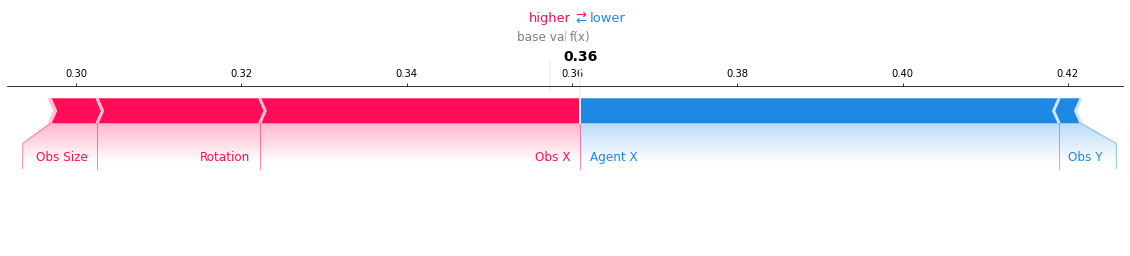

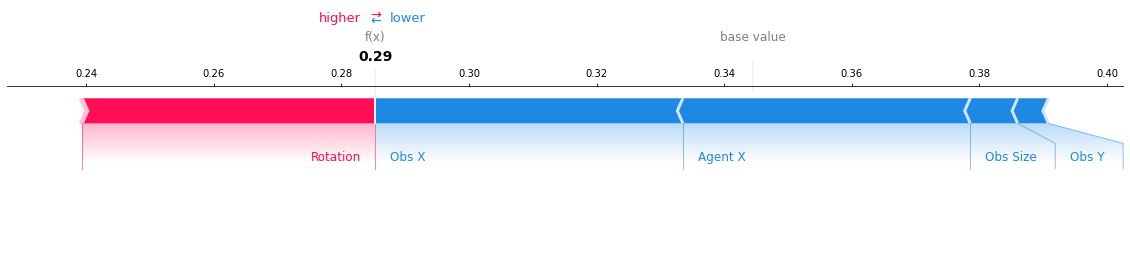

avoid the wall


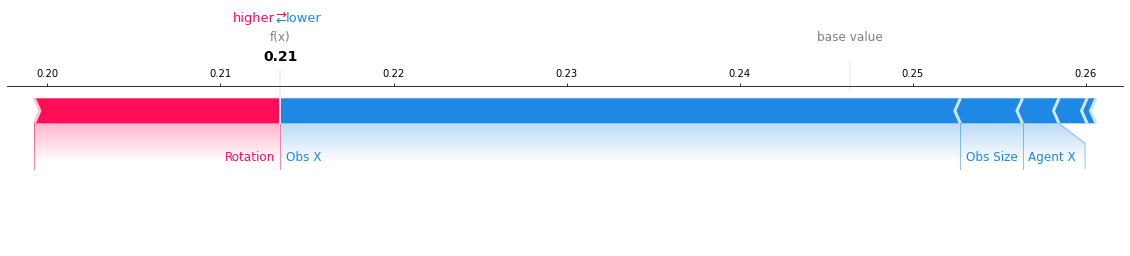

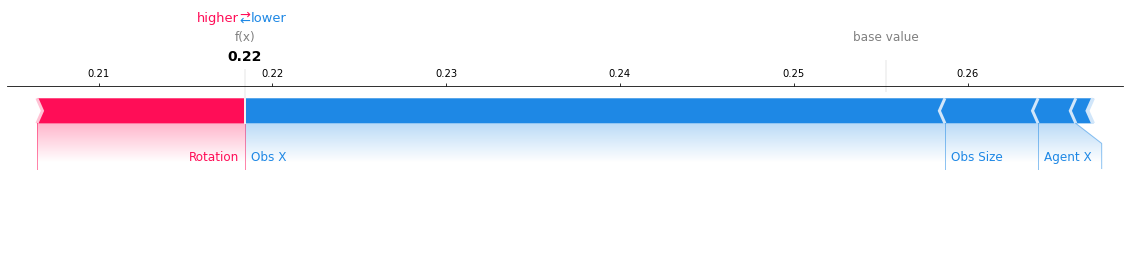

asdf


KeyboardInterrupt: 

In [7]:
if __name__ == '__main__':
    import silence_tensorflow
    silence_tensorflow.silence_tensorflow()

    #시뮬레이션 테스트 코드
    n_runs = 1000
    for k in range(1):
        model_path = f'./models/q_20230226(0)'

        #train_scores_1 = np.genfromtxt('20221003_concat_train_scores_1.csv', delimiter=',')

        wins = 0
        agent = Agent(lr=0, gamma=0.99, n_actions=5, batch_size=64, epsilon=0.0, input_dims=[1, 7], per_on=False)

        agent.load_model(model_path)

        sim = DriveSimulator()
        avg_score = 0.0


        collect_bg = 1
        background = []

        for i in range(n_runs):
            over = False
            sim.reset(frame_rate=3000)
            state = sim.get_sim_state()

            print(i)
            if i >= collect_bg:
                sim.explain = True
                bg = (np.array(background))
                e_0 = shap.DeepExplainer(agent.q_evals[0], bg[0] )
                e_1 = shap.DeepExplainer(agent.q_evals[1], bg[0] )
                e_2 = shap.DeepExplainer(agent.q_evals[2], bg[0] )
                shap.initjs()

            while not over:

                if sim.explain:
                    for event in pygame.event.get():
                        if event.type == pygame.KEYDOWN and event.key in [pygame.K_SPACE, pygame.K_RIGHT]: #키 입력 시에만 프레임 넘김
                            #행동 선택
                            action, pred, pred_C = agent.choose_action(state)
                            hesFlag = False

                            #SHAP Explainer -> 현재 state에서 가장 중요한 정보 찾기
                            shap_values = []
                            shap_values.append(np.reshape(e_0.shap_values( state ), (5,7)))
                            shap_values.append(np.reshape(e_1.shap_values( state ), (5,7)))
                            shap_values.append(np.reshape(e_2.shap_values( state ), (5,7)))
                            shap_values = np.array(shap_values)
                            
                            pred_exp, chosen, compare = pred_explain(pred_C)
                            shap_exp = shap_explain(np.sum(shap_values, axis=0)[action])
                            
                            if event.key == pygame.K_SPACE:
                               print(pred_label[0])
                               shap.force_plot(e_0.expected_value[chosen].numpy(), e_0.shap_values(state)[chosen],\
                                                features = state_label, matplotlib=True)
                               shap.force_plot(e_0.expected_value[compare].numpy(), e_0.shap_values(state)[compare],\
                                                features = state_label, matplotlib=True)
                               print(pred_label[1])
                               shap.force_plot(e_1.expected_value[chosen].numpy(), e_1.shap_values(state)[chosen],\
                                                features = state_label, matplotlib=True)
                               shap.force_plot(e_1.expected_value[compare].numpy(), e_1.shap_values(state)[compare],\
                                                features = state_label, matplotlib=True)
                               print(pred_label[2])
                               shap.force_plot(e_2.expected_value[chosen].numpy(), e_2.shap_values(state)[chosen],\
                                                features = state_label, matplotlib=True)
                               shap.force_plot(e_2.expected_value[compare].numpy(), e_2.shap_values(state)[compare],\
                                                features = state_label, matplotlib=True)
                               hesFlag = True

                            #시뮬레이션 업데이트
                            state_, stpRwd, sim_over = sim.step(action, pred_C, hesFlag=hesFlag)
                            over = sim_over
                            state = state_

                            #설명(SHAP+Reward Decomposition) 화면에 표시
                            sim.render_explanation(shap_exp, pred_exp)

                else:
                    background.append(np.array(state))
                
                    action, pred, pred_C = agent.choose_action(state)
                    state_, stpRwd, sim_over = sim.step(action, pred_C)
                    over = sim_over
                    state = state_
                 
            avg_score += sim.agtRwd
            if sim.agtRwd[0] > 0:
                wins+=1

        print(wins)